In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm

import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift


import act_max_util as amu

from autoencoder import NonLinearAutoencoder
from solver import *
from model_utils import *

In [3]:
# MNIST normalisation
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False, num_workers=6)

In [61]:
test_images = np.zeros((10000, 28, 28))
test_labels = np.zeros(10000)

current_idx = 0

for images, labels in test_loader:
    batch_size = images.size(0)
    
    images_np = images.numpy().squeeze(axis=1)
    labels_np = labels.numpy()
    
    test_images[current_idx:current_idx + batch_size] = images_np
    test_labels[current_idx:current_idx + batch_size] = labels_np
    
    current_idx += batch_size

In [70]:
sae = load_model('/home/david/mnist_model/sae/0', 'sae', 49)
dae = load_model('/home/david/mnist_model/dae/0', 'dae', 49)

/home/david/Documents/UNI_LOCAL/developing-autoencoders/model_utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/model_weights_ep

In [85]:
tensor_test_images = []
for i in range(10000):
    tensor_test_images.append(torch.tensor(test_images[i], dtype=torch.float32).reshape(-1))

In [177]:
def evaluate_model_activations(tensor_test_images, sae, dae):
    layers_to_measure = [
        'encoder_activation_1',
        'encoder_activation_2',
        'encoder_activation_3',
        'decoder_activation_1',
        'decoder_activation_2'
    ]
    
    def get_model_activations(model, image):
        with torch.no_grad():
            _, _, activations = model.forward(
                image, 
                return_activations=True
            )
        return [torch.mean(activations[layer]).item() for layer in layers_to_measure]
    
    # Process all images for both models
    sae_activations = [get_model_activations(sae, img) for img in tensor_test_images]
    dae_activations = [get_model_activations(dae, img) for img in tensor_test_images]
    
    # Calculate means across all images for both models
    return (np.mean(sae_activations, axis=0), 
            np.mean(dae_activations, axis=0), 
            np.std(sae_activations, axis=0),
            np.std(dae_activations, axis=0))

In [179]:
def evaluate_model_zeroes(tensor_test_images, sae, dae):
    layers_to_measure = [
        'encoder_activation_1',
        'encoder_activation_2',
        'encoder_activation_3',
        'decoder_activation_1',
        'decoder_activation_2'
    ]
    
    def get_zero_counts(model, image):
        with torch.no_grad():
            _, _, activations = model.forward(
                image, 
                return_activations=True
            )
        return [
                (torch.sum(activations[layer] == 0).item() / activations[layer].numel()) * 100 
                for layer in layers_to_measure
                ]
    
    # Process all images for both models
    sae_zero_counts = [get_zero_counts(sae, img) for img in tensor_test_images]
    dae_zero_counts = [get_zero_counts(dae, img) for img in tensor_test_images]
    
    # Calculate means across all images for both models
    return (np.mean(sae_zero_counts, axis=0), 
            np.mean(dae_zero_counts, axis=0), 
            np.std(sae_zero_counts, axis=0),
            np.std(dae_zero_counts, axis=0))


In [182]:
avg_sae_act, avg_dae_act = [], []
avg_sae_std, avg_dae_std = [], []

for i in range(20):
    sae = load_model(f'/home/david/mnist_model/sae/{i}', 'sae', 59)
    dae = load_model(f'/home/david/mnist_model/dae/{i}', 'dae', 59)

    sae_act_mean, dae_act_mean, sae_act_std, dae_act_std = evaluate_model_activations(tensor_test_images, sae, dae)

    avg_sae_act.append(sae_act_mean)
    avg_dae_act.append(dae_act_mean)
    avg_sae_std.append(sae_act_std)
    avg_dae_std.append(dae_act_std)

avg_sae_act = np.mean(avg_sae_act, axis=0)
avg_dae_act = np.mean(avg_dae_act, axis=0)
avg_sae_std = np.mean(avg_sae_std, axis=0)
avg_dae_std = np.mean(avg_dae_std, axis=0)

/home/david/Documents/UNI_LOCAL/developing-autoencoders/model_utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/model_weights_ep

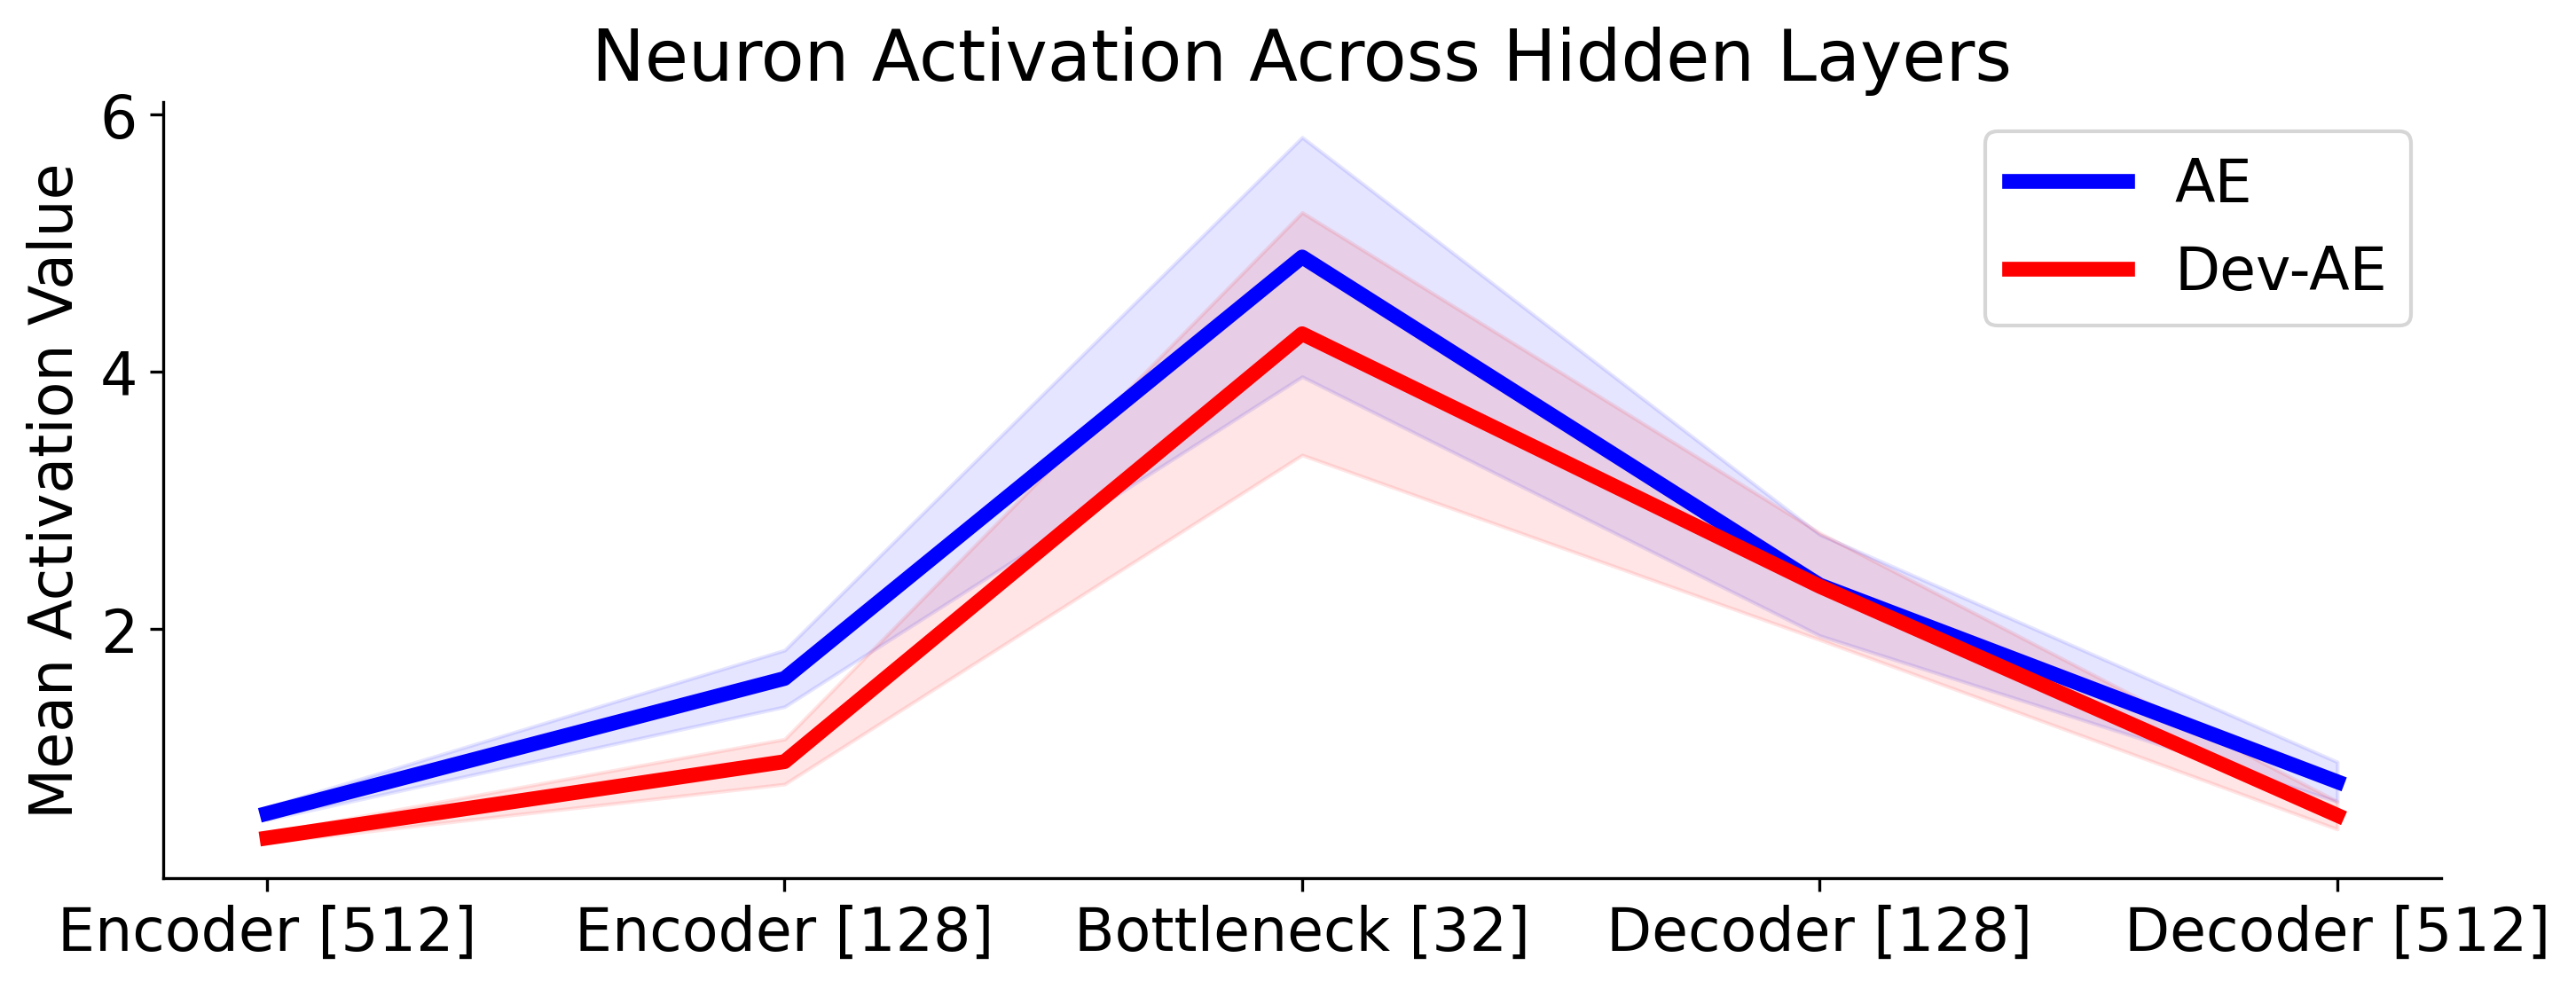

In [187]:
plt.rc('font', size=16)

plt.figure(figsize=(10, 4), dpi=300)

plt.plot(avg_sae_act, label='AE', color='blue', linewidth=4)
plt.fill_between(range(len(avg_sae_std)), 
                avg_sae_act - avg_sae_std, 
                avg_sae_act + avg_sae_std,
                color='blue', alpha=0.1)

plt.plot(avg_dae_act, label='Dev-AE', color='red', linewidth=4)
plt.fill_between(range(len(avg_dae_std)),
                avg_dae_act - avg_dae_std,
                avg_dae_act + avg_dae_std,
                color='red', alpha=0.1)

plt.title('Neuron Activation Across Hidden Layers')
plt.ylabel('Mean Activation Value')
plt.xticks(range(5), ['Encoder [512]', 'Encoder [128]', 'Bottleneck [32]', 'Decoder [128]', 'Decoder [512]'])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='upper right')
plt.tight_layout()
plt.legend()
plt.show()

In [185]:
avg_sae_zero, avg_sae_zero_std = [], []
avg_dae_zero, avg_dae_zero_std = [], []

for i in range(20):
    sae = load_model(f'/home/david/mnist_model/sae/{i}', 'sae', 59)
    dae = load_model(f'/home/david/mnist_model/dae/{i}', 'dae', 59)

    sae_zero_mean, dae_zero_mean, sae_zero_std, dae_zero_std = evaluate_model_zeroes(tensor_test_images, sae, dae)

    avg_sae_zero.append(sae_zero_mean)
    avg_dae_zero.append(dae_zero_mean)
    avg_sae_zero_std.append(sae_zero_std)
    avg_dae_zero_std.append(dae_zero_std)

avg_sae_zero = np.mean(avg_sae_zero, axis=0)
avg_dae_zero = np.mean(avg_dae_zero, axis=0)
avg_sae_zero_std = np.mean(avg_sae_zero_std, axis=0)
avg_dae_zero_std = np.mean(avg_dae_zero_std, axis=0)

/home/david/Documents/UNI_LOCAL/developing-autoencoders/model_utils.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(f"{model_path}/model_weights_ep

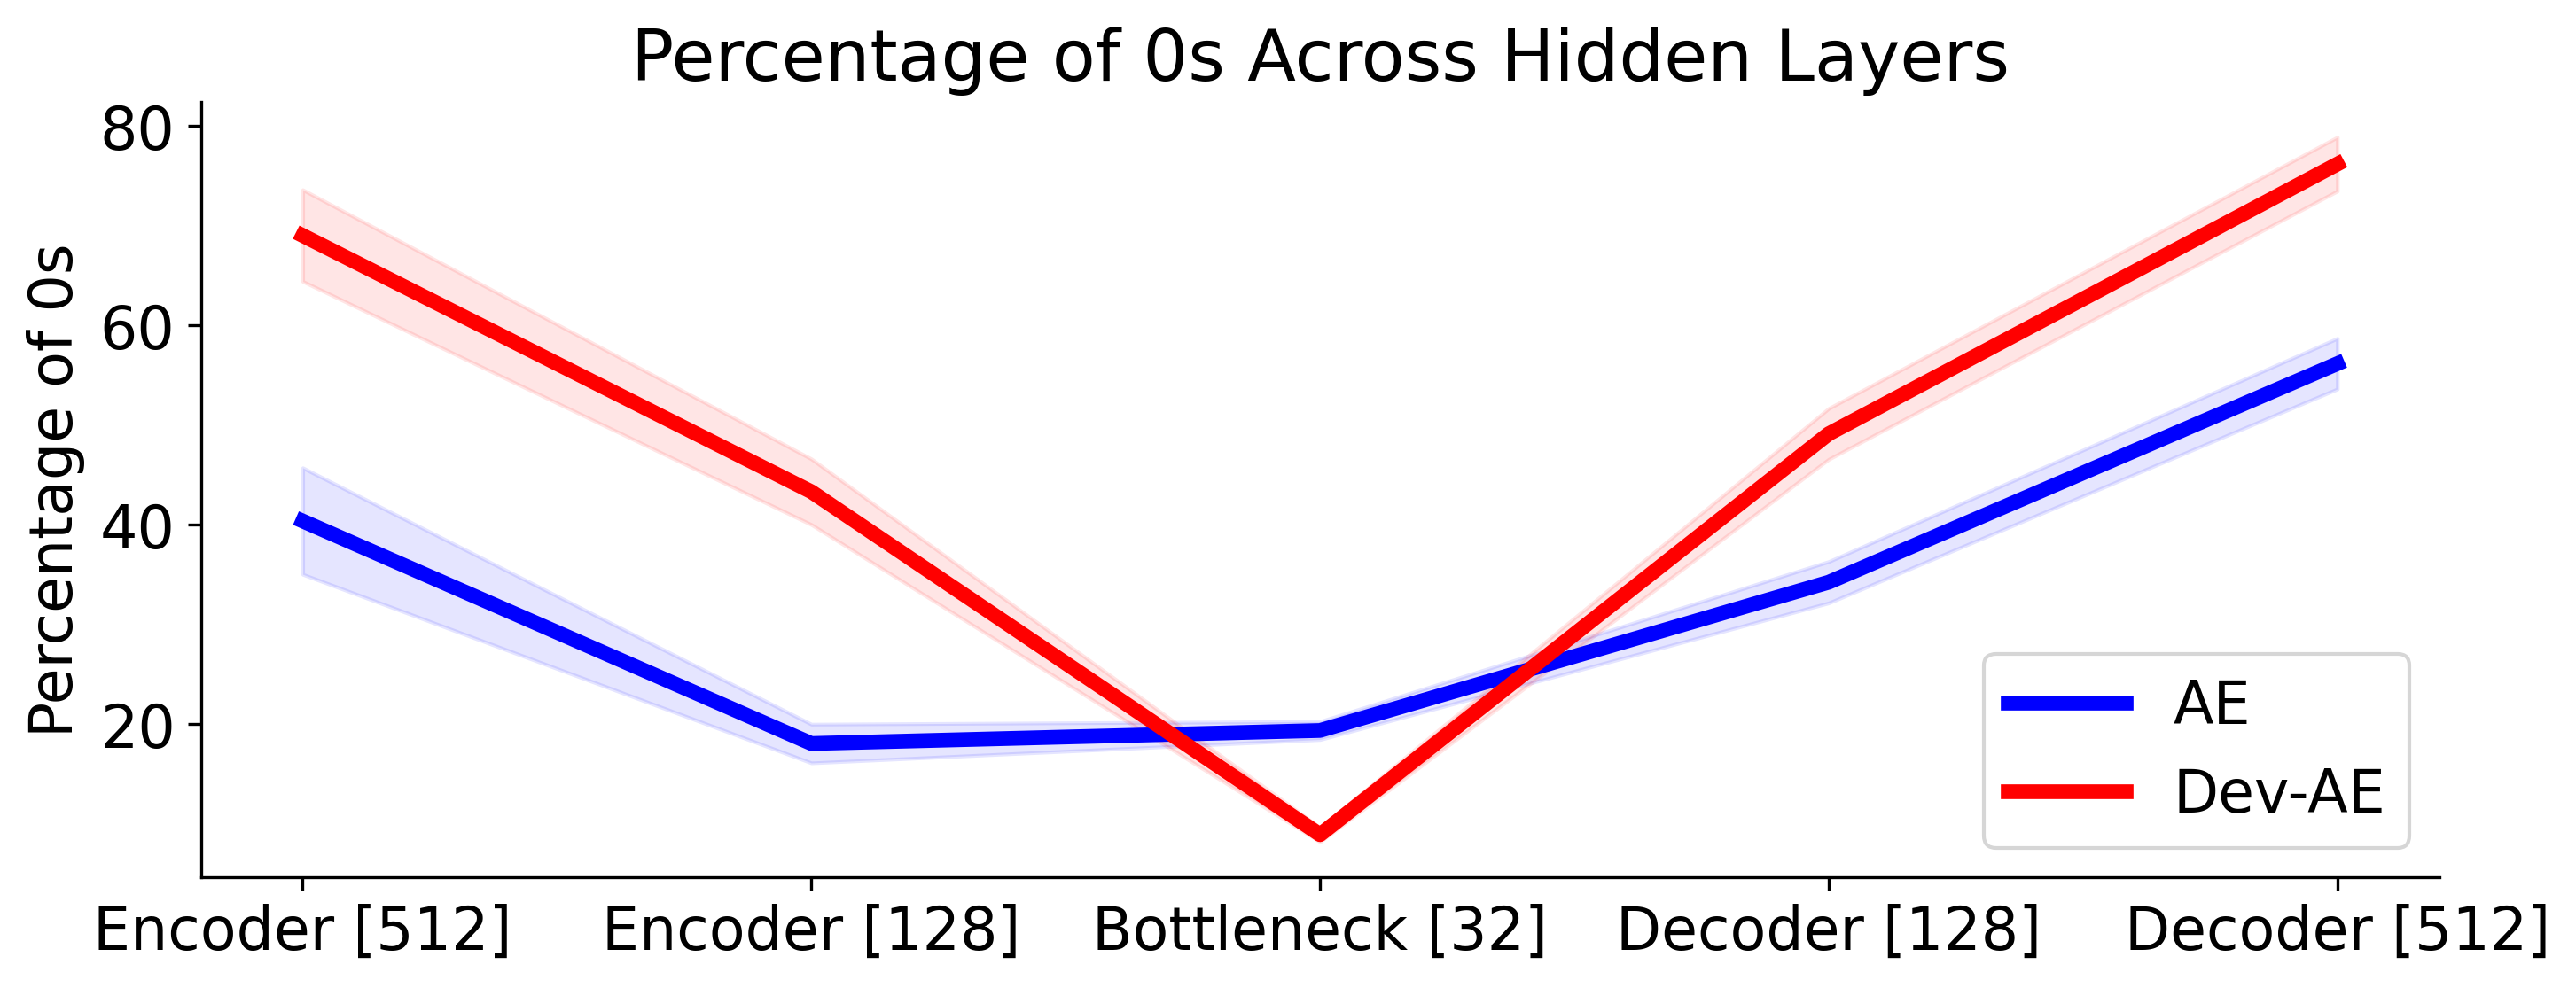

In [189]:
plt.rc('font', size=16)

plt.figure(figsize=(10, 4), dpi=300)

plt.plot(avg_sae_zero, label='AE', color='blue', linewidth=4)
plt.fill_between(range(len(avg_sae_std)), 
                avg_sae_zero - avg_sae_zero_std, 
                avg_sae_zero + avg_sae_zero_std,
                color='blue', alpha=0.1)

plt.plot(avg_dae_zero, label='Dev-AE', color='red', linewidth=4)
plt.fill_between(range(len(avg_dae_std)),
                avg_dae_zero - avg_dae_zero_std,
                avg_dae_zero + avg_dae_zero_std,
                color='red', alpha=0.1)

plt.title('Percentage of 0s Across Hidden Layers')
plt.ylabel('Percentage of 0s')
plt.xticks(range(5), ['Encoder [512]', 'Encoder [128]', 'Bottleneck [32]', 'Decoder [128]', 'Decoder [512]'])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(loc='upper right')
plt.tight_layout()
plt.legend()
plt.show()